## Laguerre-KAN for MNIST

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from LaguerreKANLayer import LaguerreKANLayer

In [10]:
alpha_1 = 0
alpha_2 = -0.5
alpha_3 = 3

# Construct a LaguerreKAN for MNIST
class MNISTLaguerreKAN(nn.Module):
    def __init__(self):
        super(MNISTLaguerreKAN, self).__init__()
        self.laguerrekan1 = LaguerreKANLayer(28*28, 64, 5, alpha_1)
        self.ln1 = nn.LayerNorm(64) # To avoid gradient vanishing caused by tanh
        self.laguerrekan2 = LaguerreKANLayer(64, 32, 3, alpha_2)
        self.ln2 = nn.LayerNorm(32)
        self.laguerrekan3 = LaguerreKANLayer(32, 16, 7, alpha_3)
        self.ln3 = nn.LayerNorm(16)
        self.laguerrekan4 = LaguerreKANLayer(16, 10, 3, alpha_3)

        # Regularization layers
        self.dropout = nn.Dropout(0.05)  # Dropout layer with p=0.05
        #self.norm1 = nn.BatchNorm1d(32)  # Batch normalization for output with 32 dimensions
        #self.norm2 = nn.BatchNorm1d(16)  # Batch normalization for output with 16 dimensions
        
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.laguerrekan1(x)
        x = self.ln1(x)
        #x = self.norm1(x)  # Apply batch normalization after the first layer
        x = self.dropout(x)  # Apply dropout after the first layer
        x = self.laguerrekan2(x)
        x = self.ln2(x)
        #x = self.norm2(x)
        x = self.dropout(x)
        x = self.laguerrekan3(x)
        x = self.ln3(x)
        x = self.laguerrekan4(x)
        return x

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTLaguerreKAN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
optimizer = optim.Adam(model.parameters(), lr=0.00015)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

Total trainable parameters: 314208


Epoch 1, Train Loss: 1.2610, Test Loss: 0.4056, Test Acc: 0.89
Epoch 2, Train Loss: 0.3552, Test Loss: 0.2553, Test Acc: 0.92
Epoch 3, Train Loss: 0.2692, Test Loss: 0.2481, Test Acc: 0.93
Epoch 4, Train Loss: 0.2293, Test Loss: 0.1849, Test Acc: 0.95
Epoch 5, Train Loss: 0.2046, Test Loss: 0.1578, Test Acc: 0.95
Epoch 6, Train Loss: 0.1875, Test Loss: 0.1697, Test Acc: 0.95
Epoch 7, Train Loss: 0.1705, Test Loss: 0.1442, Test Acc: 0.96
Epoch 8, Train Loss: 0.1615, Test Loss: 0.1427, Test Acc: 0.96
Epoch 9, Train Loss: 0.1496, Test Loss: 0.1308, Test Acc: 0.96
Epoch 10, Train Loss: 0.1437, Test Loss: 0.1297, Test Acc: 0.96
Epoch 11, Train Loss: 0.1354, Test Loss: 0.1221, Test Acc: 0.96
Epoch 12, Train Loss: 0.1310, Test Loss: 0.1473, Test Acc: 0.96
Epoch 13, Train Loss: 0.1259, Test Loss: 0.1308, Test Acc: 0.96
Epoch 14, Train Loss: 0.1176, Test Loss: 0.1094, Test Acc: 0.97
Epoch 15, Train Loss: 0.1122, Test Loss: 0.1166, Test Acc: 0.97
Epoch 16, Train Loss: 0.1128, Test Loss: 0.1291, 

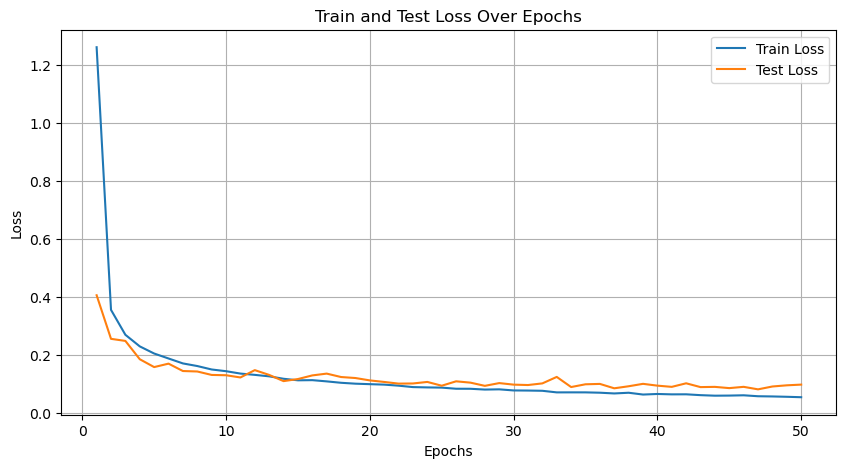

In [12]:
train_losses = []
test_losses = []

epochs = 50 # 50
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Take a peek at what the Laguerre Polynomials look like

In [13]:
alpha_1 = 0
alpha_2 = -0.5
alpha_3 = 3

def laguerre_polynomials(x, degree, alpha):
    if degree == 0:
        return np.ones_like(x)  # L_0^α(x) = 1
    elif degree == 1:
        return 1 + alpha - x  # L_1^α(x) = 1 + α - x

    # Initialize arrays for storing polynomial values
    Ln_2 = np.ones_like(x)  # L_0^α(x)
    Ln_1 = 1 + alpha - x    # L_1^α(x)
    Ln = None

    for n in range(1, degree):
        # Coefficients for the recurrence relation
        A_n = 2 * (n-1) + 1 + alpha - x
        B_n = (n-1) + alpha
        # Compute current polynomial using the previous two
        Ln = (A_n * Ln_1 - B_n * Ln_2) / (n)
        
        # Update the polynomials for the next iteration
        Ln_2, Ln_1 = Ln_1, Ln

    return Ln


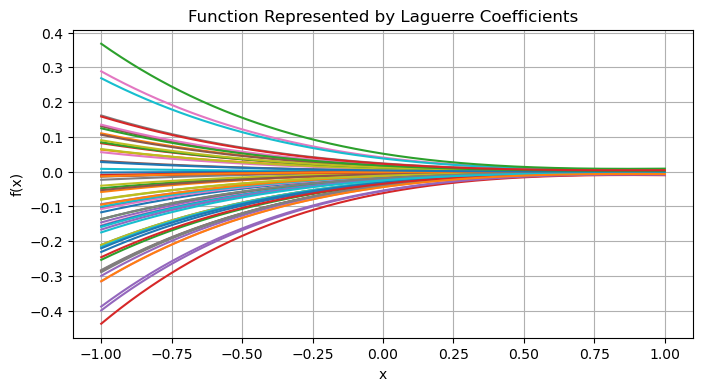

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.laguerrekan1.laguerre_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[28 * 28 // 2]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * laguerre_polynomials(x_values, i, alpha_1)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Laguerre Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

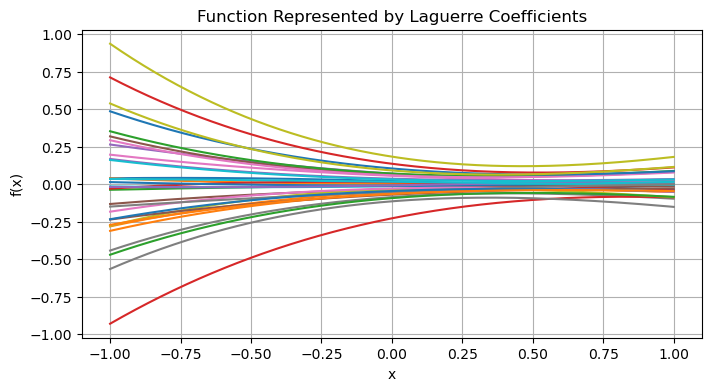

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.laguerrekan2.laguerre_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[16]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * laguerre_polynomials(x_values, i, alpha_2)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Laguerre Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

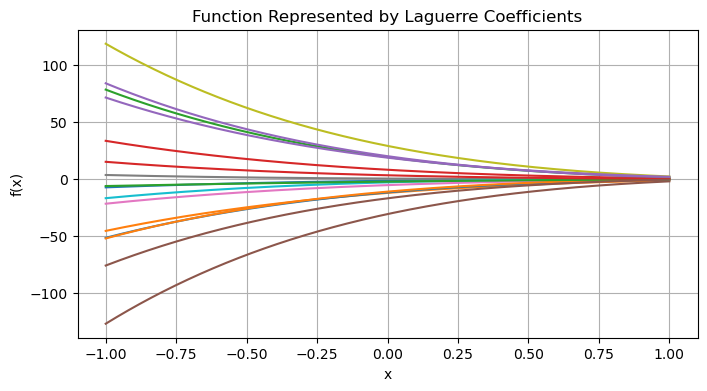

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.laguerrekan3.laguerre_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[8]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * laguerre_polynomials(x_values, i, alpha_3)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Laguerre Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()